# Functional Connectivity

- **Created:** November 2024 by [Rik Henson](https://www.mrc-cbu.cam.ac.uk/people/rik.henson/) 
- **conda environment**: Needs the [fMRI workshop's conda environment](https://github.com/MRC-CBU/COGNESTIC/blob/main/mri_environment.yml) to run this notebook and any accompanied scripts.

## Beta-series regression

Let's load up the single-trial Betas from 

## Getting Ready

As usual, we need some python packages like below:

In [147]:
import numpy as np              # This lets python process matrices, like Matlab
import matplotlib.pyplot as plt # This lets python plot graphs like Matlab
import seaborn as sns           # This provides another popular set of plotting functions
import pandas as pd             # To use "dataframes" (like tables in Matlab)
import os                       # To interact with the operating system, including files and paths (e.g. path.join)
import time                     # To use "time" (like "tic" in Matlab)

# Nilearn modules, for the analysis of brain volumes, plotting, etc., https://nilearn.github.io/
import nilearn as nl           # Many useful functions for MRI, including...
from nilearn import image       # to load (load_img), resample (resample_to_img), manipulate (math_img) fMRI data, etc.
from nilearn import datasets    # includes e.g. fetch_atlas_harvard_oxford
from nilearn import masking
from nilearn import input_data  # includes NiftiMasker, NiftiLabelsMasker
from nilearn import plotting    # includes plot_roi, plot_stat_map, view_img_on_surf, etc.
from nilearn import decoding    # includes Searchlight
from nilearn.plotting import plot_design_matrix, plot_contrast_matrix, plot_stat_map, plot_roi
from nilearn.glm.first_level import FirstLevelModel, compute_regressor, spm_hrf
from nilearn.glm.thresholding import threshold_stats_img
from nilearn.maskers import NiftiMasker, NiftiSpheresMasker

from bids.layout import BIDSLayout # to fetch data from BIDS-compliant datasets

import nibabel as nib # NiBabel, to read and write neuroimaging data, https://nipy.org/nibabel/

from scipy.stats import pearsonr
%matplotlib inline

In [ ]:
wd = '/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/' # <-- CHANGE TO YOURS
os.chdir(wd)
#print(f"Working directory currently {os.getcwd()}")

# Make new directory for output
output = os.path.join(wd, 'mvpa')
if not os.path.exists(output):
    os.makedirs(output)
print(f"Output directory {output}")

In [ ]:
fmri_data_dir = 'data' # data in BIDS format
fmri_results_dir = 'results' # results in BIDS format

# --- Set up the BIDS layout
layout = BIDSLayout(fmri_data_dir, derivatives = True)
# Attach the results folder to the layout. 
layout.add_derivatives(os.path.join(fmri_results_dir, "first-level"))

In [38]:
sID = '15'

bold = layout.get(subject = sID, datatype = 'func', desc = 'preproc', extension = '.nii.gz', return_type = 'filename')
print("Found " + str(len(bold)) + " preprocessed functional files")

events_files = layout.get(subject=sID, datatype='func', suffix='events', extension=".tsv", return_type='filename')
print("Found " + str(len(events_files)) + " event files")

model_name = 'LSA_2FF_2SF' 
outdir = os.path.join(output, model_name, 'sub-' + sID)

conditions = ['IniFF', 'ImmFF', 'DelFF', 'IniUF', 'ImmUF', 'DelUF', 'IniSF', 'ImmSF', 'DelSF']
conditions_of_interest = ['IniFF', 'DelFF', 'IniSF', 'DelSF']
other_conditions = [val for val in conditions if val not in conditions_of_interest]

lsa_events = []
for run, events_file in enumerate(events_files):
    events_df = pd.read_table(events_file)
    for j, event in enumerate(events_df['trial_type']):
        if event in conditions_of_interest:
            events_df.loc[j, 'trial_type'] = event + events_df['stim_file'][j][-8:-4]
    lsa_events.append(events_df)

img_4d_fname = []
trial_labels = []
for run in range(len(bold)):
    img_4d_fname.append(os.path.join(outdir, os.path.basename(bold[run]).split("space")[0] + model_name + '_betas.nii.gz'))
    trials_to_save = lsa_events[run]["trial_type"]
    trials_to_save = [val for val in trials_to_save if val not in other_conditions]
    trials_to_save = [label[3:5] for label in trials_to_save]
    trial_labels.extend(trials_to_save)

print(img_4d_fname[0])
#print(labels_per_run)

Found 9 preprocessed functional files
Found 9 event files
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-01_LSA_2FF_2SF_betas.nii.gz


### ROI to ROI

Let's define again the functional fusiform ROI and the anatomical amygdala ROI

In [11]:
amyg_ROI = nib.load(os.path.join(fmri_results_dir,'amygdala_mask.nii.gz'))
print(amyg_ROI.get_fdata().shape)
amyg_ROI = nl.image.resample_to_img(amyg_ROI, img_4d_fname[0], interpolation='nearest') # resample ROI to bold resolution to save time when estimating glm below
print(amyg_ROI.get_fdata().shape)

fusi_ROI = nib.load(os.path.join(fmri_results_dir,'sphere_and_faces-scrambled_Zmap_fdr.nii.gz'))
# shouldn't need to resample fusi ROI, but just to be safe!
fusi_ROI = nl.image.resample_to_img(fusi_ROI, img_4d_fname[0], interpolation='nearest') 

amyg_masker = nl.input_data.NiftiMasker(amyg_ROI)
fusi_masker = nl.input_data.NiftiMasker(fusi_ROI)

(64, 76, 64)
(97, 115, 97)


In [79]:
fusi_data_per_run = []
amyg_data_per_run = []
for run in range(len(img_4d_fname)):
    print(img_4d_fname[run])
    
    fusi_data = fusi_masker.fit_transform(img_4d_fname[run])
    fusi_data = np.mean(fusi_data, axis=1) # average across voxels
    fusi_data_per_run.append(fusi_data)

    amyg_data = amyg_masker.fit_transform(img_4d_fname[run])
    amyg_data = np.mean(amyg_data, axis=1) # average across voxels
    amyg_data_per_run.append(amyg_data)

fusi_data = np.concatenate(fusi_data_per_run, axis=0)
amyg_data = np.concatenate(amyg_data_per_run, axis=0)
print(fusi_data.shape)

/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-01_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-02_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-03_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-04_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-05_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-06_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_tas

In [113]:
trials_per_condition = []
conditions = list(set(trial_labels))
for con, condition in enumerate(conditions):
    trials_per_condition.append([i for i, x in enumerate(trial_labels) if x == condition])
    print(f'{len(trials_per_condition[con])} {condition} trials')

202 SF trials
212 FF trials


<Figure size 640x480 with 0 Axes>

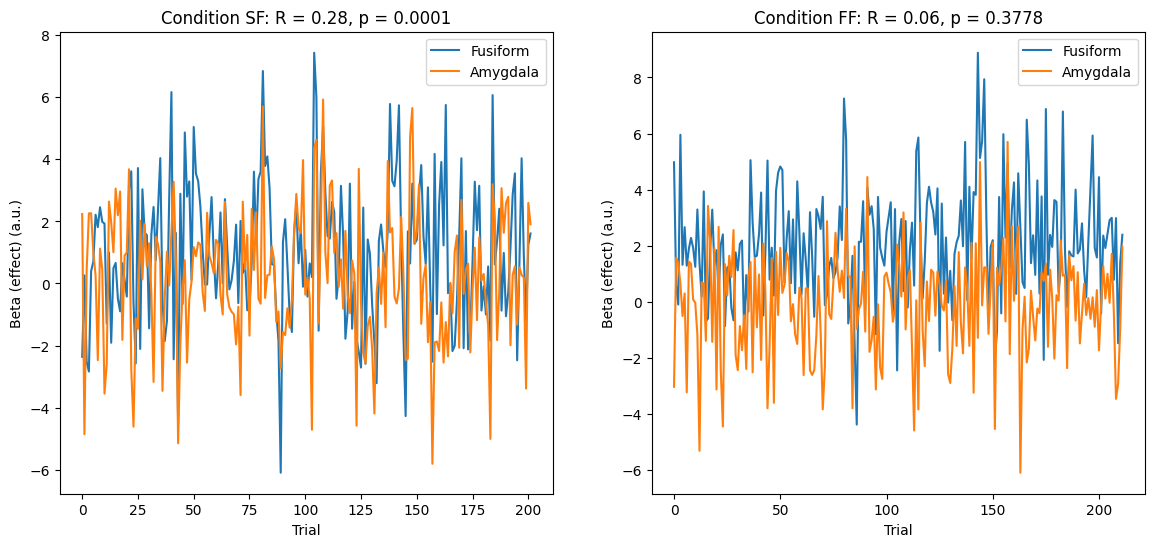

In [213]:
plt.figure(); 
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,6));

Rval_data = []
for ax in range(len(axs.flat)):
    axs[ax].plot(fusi_data[trials_per_condition[ax]]);
    axs[ax].plot(amyg_data[trials_per_condition[ax]]);
#    axs[ax].plot(fusi_data[trials_per_condition[ax]], amyg_data[trials_per_condition[ax]],'o');
    axs[ax].set_xlabel('Trial');
    axs[ax].set_ylabel('Beta (effect) (a.u.)');
    axs[ax].legend(['Fusiform', 'Amygdala']);
    pcor = pearsonr(fusi_data[trials_per_condition[ax]], amyg_data[trials_per_condition[ax]])
    axs[ax].set_title('Condition ' + conditions[ax] + ": R = " + str(round(pcor.statistic,2)) + ", p = " + str(round(pcor.pvalue,4)));
    Rval_data.append(pcor.statistic)

Permuted p-value for difference in Z-values being as big as 0.21 is 0.015


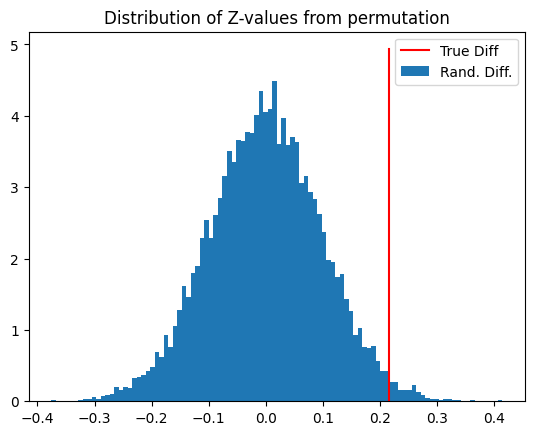

In [232]:
num_rand = int(1e4) # Number of randomisations
Rval = np.empty([len(conditions),num_rand])
for con, condition in enumerate(conditions):
    fusi_samp = fusi_data[trials_per_condition[con]]
    
    for r in range(num_rand):
        amyg_perm = np.random.permutation(amyg_data[trials_per_condition[con]])
        pcor = pearsonr(fusi_samp, amyg_perm)
        Rval[con,r] = pcor.statistic

Rval_dif_data = Rval_data[0] - Rval_data[1]
Rval_dif_perm = Rval[0,:] - Rval[1,:]

# Convert to Z-values using Fisher transform (atanh)
#Zval_dif_data = np.arctanh(Rval_data[0]) - np.arctanh(Rval_data[1])
#Zval_dif_perm = np.arctanh(Rval[0,:]) - np.arctanh(Rval[1,:])

pdf, bin_edges = np.histogram(Rval_dif_perm, bins=100, density=True)
plt.figure(); plt.bar((bin_edges[:-1] + bin_edges[1:]) / 2, pdf, width=bin_edges[1] - bin_edges[0])
plt.plot([Rval_dif_data, Rval_dif_data], [0, 1.1*np.max(pdf)], 'r-')
plt.title('Distribution of Z-values from permutation'); plt.legend(['True Diff', 'Rand. Diff.']);

pval = (np.sum(np.abs(Rval_dif_perm) >= np.abs(Rval_dif_data)) + 1) / (2*num_rand + 1)
print(f'Permuted p-value for difference in Z-values being as big as {round(Rval_dif_data,2)} is {round(pval,3)}')

univariate connectivity - multivariate connectivity do exist, where do not average across voxels (review)

### ROI to whole brain

Let's map out connectivity across brain

In [237]:
brain_masker = NiftiMasker(smoothing_fwhm=10)

brain_data_per_run = []
for run in range(len(img_4d_fname)):
    print(img_4d_fname[run])
    brain_data = brain_masker.fit_transform(img_4d_fname[run])
    brain_data_per_run.append(brain_data)
    
brain_data = np.concatenate(brain_data_per_run, axis=0)
print(brain_data.shape)

/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-01_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-02_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-03_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-04_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-05_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-06_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_tas

In [238]:
indices = trials_per_condition[0] # conditions[0]
brain_corrs_con1 = np.dot(fusi_data[indices].T, brain_data[indices,])  # Pearson correlation proportional to dot product 
brain_corrs_con1 = brain_corrs_con1 / (np.linalg.norm(fusi_data[indices]) * np.linalg.norm(brain_data[indices,], axis=0))
#brain_corrs_con1 = np.arctanh(brain_corrs_con1) # Fisher Transform R value to Z value

indices = trials_per_condition[1] # conditions[1]
brain_corrs_con2 = np.dot(fusi_data[indices].T, brain_data[indices,])  # Pearson correlation proportional to dot product 
brain_corrs_con2 = brain_corrs_con2 / (np.linalg.norm(fusi_data[indices]) * np.linalg.norm(brain_data[indices,], axis=0))
#brain_corrs_con2 = np.arctanh(brain_corrs_con2) # Fisher Transform R value to Z value

In [265]:
difZ = np.arctanh(brain_corrs_con2) - np.arctanh(brain_corrs_con1) # 2-1 for Faces > Scrambled
Zdif = difZ / np.sqrt( 1 / (len(trials_per_condition[0]) - 3) + 1 / (len(trials_per_condition[1]) - 3) ) # Fisher method for comparing two independent correlations
#two-tailed
pval = scipy.stats.norm.cdf(-abs(Zdif)) + 1-scipy.stats.norm.cdf(abs(Zdif))

# Determine p-value from same null used above - not strictly correct since assumes null from amygdala ROI same for all voxels
# Rval_dif_data = brain_corrs_con2 - brain_corrs_con1
# pval = np.empty([len(Rval_dif_data)])
# for v in range(len(Rval_dif_data)):
#     pval[v] = (np.sum(np.abs(Rval_dif_perm) >= np.abs(Rval_dif_data[v])) + 1) / (2*num_rand + 1)
# sval = np.sign(Rval_dif_data)

sval = np.sign(difZ)
pval = sval * -np.log10(pval)

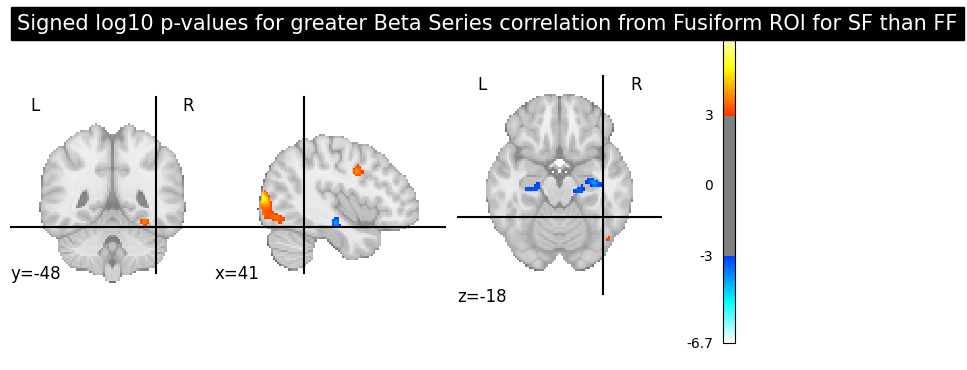

In [266]:
brain_diff_con_img = brain_masker.inverse_transform(pval)
fusi_coords = (41.5, -48.5, -18.5) # from nb06
display = plotting.plot_stat_map(brain_diff_con_img, cut_coords=fusi_coords, threshold = -np.log10(0.001),
    title="Signed log10 p-values for greater Beta Series correlation from Fusiform ROI for " + conditions[1] + " than " + conditions[0])